In [123]:
#Análisis de datos para el modelo angular 

import matplotlib.pyplot as plt
import pandas as pd
import csv
import numpy as np
from scipy.optimize import curve_fit
from scipy.stats import kurtosis

# MODULO PARA SIMULACIONES
# Nomenclatura:
#   PO: Parámetro de Orden (Order Parameter)
#   t: tiempo (time)
#   X: variable que evoluciona con el tiempo y tiene como parámetro PO. (variable X[t,PO])

def ReadParameters(InFile,N,v0,rho,MidoCada,printing):
    with open(InFile) as f_in_names:
    
        plots=csv.reader(f_in_names,delimiter = ' ')
        Naux=int(f_in_names.readline().split()[1])
        N.append(Naux)
        L=int(f_in_names.readline().split()[1])
        v0.append(float(f_in_names.readline().split()[1]))
        for i in range(5):
            next(plots)
        MidoCada.append(int(f_in_names.readline().split()[1]))
        rho.append(Naux/L**2)
        if printing == True:
            print('N = %s' % N)
            print('rho = %s' % rho)
            print( r'$\Delta$ t = %s' % MidoCada)
    
    return 
# función para leer las tablas .dat


def Autocorr(x):
    result = np.correlate(x, x, mode='full')
    return result[int(result.size/2):]


#creamos una rutina que calcula el tiempo de equilibración
#distingue si es mayor a un dado límite o no
def ExtractTauEq(noise,f_fit,time,ACT,lowerBound):
    TauEq=[]
    for j in range(len(noise)):
        tau_temp=curve_fit(f_fit,time,ACT[j], maxfev = 50000)[0][0]
        if tau_temp <= lowerBound:
            TauEq.append(lowerBound)
        else:
            TauEq.append(tau_temp)
        
    return TauEq


""" La función Graficador """
# -------------- ACLARACIONES --------------
# el parámetro 'grafico' es una lista cuyos elementos
# contienen la siguiente información, en el siguiente orden:
# grafico[0]=[x,y,yerr,fmt,label]
# x: variable indepentiente
# y: variable dependiente
# yerr: error de variable dependiente
# fmt: formato, es de tipo string
# label: etiquieta, tipo string
#-------------- EJEMPLO -------------
#grafico=[[graf1][graf2][graf3]]
#graf1=[x,y,yEr,'g-',label]
#----------------------------
def Graficador(grafico,xlabel,ylabel,title):
# =============================================================================
#     print("grafico=[[graf1][graf2][graf3]]")
#     print("graf1=[x,y,yEr,'g-',label]")
# =============================================================================
    assert type(grafico[0])==list, 'missing brakets in "grafico" '
    for item in grafico:
        plt.errorbar(
                item[0],
                item[1],
                yerr = item[2],
                fmt=item[3],
                ecolor='k',
                label = item[4] )
    
    plt.xlabel(xlabel,fontsize = 15)
    plt.ylabel(ylabel,fontsize = 15)
    plt.title(title)
    plt.legend()
    plt.show()
    return
""" END función Graficador """


class AnalysisVicsek(object):
    
    
    def __init__(self,runNbr,inFiles,typeAnalysis,parameters):
        self.runNbr = runNbr
        self.inFiles = inFiles
        assert len(inFiles)==3, 'Must privide a 3 length list'
        self.typeAnalysis = typeAnalysis
        self.parameters = parameters
        self.M_Period = parameters[3] #period of messurements
#        self.tauEq = 0

        return


    #from inFiles read Parameters and Variables

    def getVariables(self, fileToRead):
        with open(fileToRead, 'r') as archivo:
            noise=np.asarray(archivo.readline().split()[1::],float)
            lines=archivo.readlines()
            result=[]
            for x in lines:
                result.append(x.split( )[0])
    
            result2=[float(result[i]) for i in range(1,len(result))]
            time=np.asarray(result2, float)
            lines2=[lines[i] for i in range(1, len(result2)+1)]
            X3=[]
            for i in range(1,len(noise)+1):
                X2=[]
                for x in lines2:
                    X2.append(x.split( )[i])
                X3.append(X2)
        
            X=np.asarray(X3,float)
    
        return noise, time, X  
   
    # Set noise
    @property
    def vicsekNoise(self):
        return self.getVariables(self.inFiles[1])[0]
    
    def _calc_acorr(self,tEq):
        print('tEq is a presumed time of equilibration different than tauEq')
        first=int(tEq/self.M_Period)
        Acorr=[]
        OP=self.get_OrderParam
        for k in range(len(self.vicsekNoise)):
            # estimate Acorr from an stabilized array
            Acorr.append(Autocorr(OP[k][first::]))
    
        return np.array(Acorr,float)
    
    @property
    def acorrTime(self,t_f=200):
        # we save only up to len(OP)/2 because after that we have little
        # amount of points to estimate Acorr with few error.
#        t_f=250
        time=self.getVariables(self.inFiles[0])[1][:t_f]

        return np.asarray(time,float)
    
    @property
    def acorr(self):
        Acorr = self.getVariables(self.inFiles[0])[2][:,:200]
        return np.asarray(Acorr,float)
    
    
    #Now we need to extract the equilibrium time 'tauEq'.
    def get_tauEq(self,FittingFunction):
        #check dimensions
        #check the way the function is defined
        print('CAREFUL: FittingFunction must be like F(x,tau,A,y0,**p)')
        #falta proteger la variable tauEq
        tauEq=ExtractTauEq(
                self.vicsekNoise,
                FittingFunction,
                self.acorrTime,
                self.acorr,
                self.M_Period
                )
#        self.tauEq = np.array(tauEq,float)
        print(tauEq)
        return np.array(tauEq,float)
    

    #get order parameter time array
    @property
    def get_OPtime(self):    
        return self.getVariables(self.inFiles[1])[1]
    #get order parameter array
    @property
    def get_OrderParam(self):
        return self.getVariables(self.inFiles[1])[2]
    
    
    # calculate the mean,var and kurtosis of the variable X from an initial time tauEq
    def _calc_X_Stats(self,X,tauEq):   
        X_mean=[]
        X_var=[]
        X_kurt=[]
        for k in range(len(self.vicsekNoise)):
            aux_t=self.M_Period
            tauEq[k]/=aux_t
            # tauEq[k]/=self.M_Period
            X_mean.append(np.mean(X[k][int(tauEq[k]):]))
            X_var.append(np.var(X[k][int(tauEq[k]):]))
            X_kurt.append(kurtosis(X[k][int(tauEq[k]):],fisher=True))
            # tauEq[k]*=self.M_Period #idk how to avoid de method to change the original value.. so re calc
        X_mean=np.asarray(X_mean,float)
        X_var=np.asarray(X_var,float)
        X_kurt=np.asarray(X_kurt,float)
        return X_mean,X_var,X_kurt
       
    def get_OP_Mean(self,tauEq):
        OPMean = self._calc_X_Stats(self.get_OrderParam,tauEq)[0]
        return OPMean
    
    def get_OP_Var(self,tauEq):
        OPVar = self._calc_X_Stats(self.get_OrderParam,tauEq)[1]
        return OPVar
    
    """ CumulanteBinder = CB_A = 1- <Phi^4>/3*<Phi^2>^2"""
    def _calc_X_BinderCumulant(self,tauEq):
        BindCum = 1 -self._calc_X_Stats(self.get_OrderParam,tauEq)[2]/3
        return BindCum
    

    def ErrOP(self,tauEq):
        errOP=[]
        for k in range(len(self.vicsekNoise)):
            if tauEq[k]<=self.M_Period:
                n=len(self.get_OPtime)
                errOP.append(np.sqrt(self.get_OP_Var(tauEq)[k]/(n-1)))
            else:
                tmax=max(self.get_OPtime) - tauEq[k]
                n=2*tauEq[k]/tmax
                errOP.append(np.sqrt(n*self.get_OP_Var(tauEq)[k]))
    #            errOP = np.sqrt(self.get_OP_Var/(n-1))
        
        return np.array(errOP,float)
"""END OF CLASS AnalysisVicsek"""
print('fet')

fet


In [124]:
import sys
sys.path.insert(0,'C:/Users/musta')
import numpy as np
import math
import matplotlib.pyplot as plt


print('fets imports')

fets imports


In [125]:
nroFilesA=0
nroFilesV=0

InFile=[]
AngInFiles=[]
VecInFiles=[]

for j in range(10,15):
    namearch  = 'Entrada_Parametros_Vicsek'+str(j)+'.dat'
    acorrFile='Acorr_VA'+str(j)+'.dat'
    PhiFile='CrudosVicsekA'+str(j)+'.dat'
    PhiSqrFile='CrudosVicsekA'+str(j)+'_Sqr.dat'
    AngInFiles.append([acorrFile,PhiFile,PhiSqrFile])
    nroFilesA+=1
    InFile.append(namearch)
    
    
    
print('fet')
print(InFile, 'AngInFiles is:',AngInFiles, nroFilesA)

fet
['Entrada_Parametros_Vicsek10.dat', 'Entrada_Parametros_Vicsek11.dat', 'Entrada_Parametros_Vicsek12.dat', 'Entrada_Parametros_Vicsek13.dat', 'Entrada_Parametros_Vicsek14.dat'] AngInFiles is: [['Acorr_VA10.dat', 'CrudosVicsekA10.dat', 'CrudosVicsekA10_Sqr.dat'], ['Acorr_VA11.dat', 'CrudosVicsekA11.dat', 'CrudosVicsekA11_Sqr.dat'], ['Acorr_VA12.dat', 'CrudosVicsekA12.dat', 'CrudosVicsekA12_Sqr.dat'], ['Acorr_VA13.dat', 'CrudosVicsekA13.dat', 'CrudosVicsekA13_Sqr.dat'], ['Acorr_VA14.dat', 'CrudosVicsekA14.dat', 'CrudosVicsekA14_Sqr.dat']] 5


In [126]:
N=[]
v0=[]
rho=[]
MidoCada=[]

parameters=[]
for j in range(nroFilesA):
    ReadParameters(InFile[j],N,v0,rho,MidoCada,True)    
    parameters.append([N[j],v0[j],rho[j],MidoCada[j]])
    
print(parameters)

N = [225]
rho = [1.0]
$\Delta$ t = [100]
N = [225, 196]
rho = [1.0, 1.0]
$\Delta$ t = [100, 100]
N = [225, 196, 144]
rho = [1.0, 1.0, 1.0]
$\Delta$ t = [100, 100, 100]
N = [225, 196, 144, 100]
rho = [1.0, 1.0, 1.0, 1.0]
$\Delta$ t = [100, 100, 100, 100]
N = [225, 196, 144, 100, 64]
rho = [1.0, 1.0, 1.0, 1.0, 1.0]
$\Delta$ t = [100, 100, 100, 100, 100]
[[225, 1.25, 1.0, 100], [196, 1.25, 1.0, 100], [144, 1.25, 1.0, 100], [100, 1.25, 1.0, 100], [64, 1.25, 1.0, 100]]


In [127]:
VA_OBJ=[]
VV_OBJ=[]

for j in range(nroFilesA):
    VA_OBJ.append(AnalysisVicsek(j,
                                     AngInFiles[j],
                                     'A',
                                     parameters[j]))
parametersV=[parameters[k] for k in range(0,len(parameters),2)]

print(AngInFiles,VA_OBJ[0])
print(VA_OBJ[0],nroFilesA)

[['Acorr_VA10.dat', 'CrudosVicsekA10.dat', 'CrudosVicsekA10_Sqr.dat'], ['Acorr_VA11.dat', 'CrudosVicsekA11.dat', 'CrudosVicsekA11_Sqr.dat'], ['Acorr_VA12.dat', 'CrudosVicsekA12.dat', 'CrudosVicsekA12_Sqr.dat'], ['Acorr_VA13.dat', 'CrudosVicsekA13.dat', 'CrudosVicsekA13_Sqr.dat'], ['Acorr_VA14.dat', 'CrudosVicsekA14.dat', 'CrudosVicsekA14_Sqr.dat']] <__main__.AnalysisVicsek object at 0x0000020DA6719E50>
<__main__.AnalysisVicsek object at 0x0000020DA6719E50> 5


In [128]:
eta=VA_OBJ[0].vicsekNoise
print(eta)

[0.1  0.14 0.18 0.23 0.27 0.31 0.35 0.39 0.44 0.48 0.52 0.56 0.61 0.65
 0.69 0.73 0.77 0.82 0.86 0.9 ]


In [129]:
tACTANG=[]
ACTANG=[]
for j in range(nroFilesA):
    tACTANG.append(VA_OBJ[j].acorrTime)
    ACTANG.append(VA_OBJ[j].acorr)
    
print('fet')
print(tACTANG)


fet
[array([  100.,   200.,   300.,   400.,   500.,   600.,   700.,   800.,
         900.,  1000.,  1100.,  1200.,  1300.,  1400.,  1500.,  1600.,
        1700.,  1800.,  1900.,  2000.,  2100.,  2200.,  2300.,  2400.,
        2500.,  2600.,  2700.,  2800.,  2900.,  3000.,  3100.,  3200.,
        3300.,  3400.,  3500.,  3600.,  3700.,  3800.,  3900.,  4000.,
        4100.,  4200.,  4300.,  4400.,  4500.,  4600.,  4700.,  4800.,
        4900.,  5000.,  5100.,  5200.,  5300.,  5400.,  5500.,  5600.,
        5700.,  5800.,  5900.,  6000.,  6100.,  6200.,  6300.,  6400.,
        6500.,  6600.,  6700.,  6800.,  6900.,  7000.,  7100.,  7200.,
        7300.,  7400.,  7500.,  7600.,  7700.,  7800.,  7900.,  8000.,
        8100.,  8200.,  8300.,  8400.,  8500.,  8600.,  8700.,  8800.,
        8900.,  9000.,  9100.,  9200.,  9300.,  9400.,  9500.,  9600.,
        9700.,  9800.,  9900., 10000., 10100., 10200., 10300., 10400.,
       10500., 10600., 10700., 10800., 10900., 11000., 11100., 11200.,
 

In [10]:
print(VA_OBJ[0])

In [133]:
VA_OBJ[0].acorr

array([[ 1.        ,  0.02659365,  0.01315137, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.        ,  0.05204924,  0.03336435, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.        ,  0.01282715,  0.00563002, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 1.        ,  0.00611521, -0.00206918, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.        , -0.00278527, -0.00750409, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.        ,  0.00472853, -0.00429326, ...,  0.        ,
         0.        ,  0.        ]])

In [139]:
labels = [r'$\eta = %s$' % eta[j] for j in range(len(eta))]
formatACT=['k.-','r.-','m.-','c.-','b.-','g.-','y.-','gv-','kv-','rv-']

graficoACT_A=[]
for k in range(nroFilesA):
    tituloAcorr=r'Anuglar - $N = %s$, $\rho = %s$' %(N[k],rho[k])
    graficoACT_A.append(
            [[tACTANG[k],ACTANG[k][j],None,formatACT[j],labels[j]]
            for j in range(0,len(eta),3)])
    plt.figure(k)
    Graficador(graficoACT_A[k],'$t [MCS]$','$Acorr$',tituloAcorr)

IndexError: list index out of range

In [98]:
def f(x,tau,b,y0): 
    return b*np.exp(-x/tau) + y0

initGuessA=[[[MidoCada[k],ACTANG[k][j][0],0] for j in range(len(eta))]for k in range(nroFilesA)]
print(initGuessA[0], len(initGuessA))

[[200, 1.0, 0], [200, 1.0, 0], [200, 1.0, 0], [200, 1.0, 0], [200, 1.0, 0], [200, 1.0, 0], [200, 1.0, 0], [200, 1.0, 0], [200, 1.0, 0], [200, 1.0, 0], [200, 1.0, 0]] 5


In [140]:
# obtener el tiempo de eq. para cada curva de ACT
tauEq_A=[VA_OBJ[k].get_tauEq(f) for k in range(nroFilesA)]
print(tauEq_A)

CAREFUL: FittingFunction must be like F(x,tau,A,y0,**p)


C:\Users\musta\Anaconda2\envs\python3.8\lib\site-packages\scipy\optimize\minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


[100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100]
CAREFUL: FittingFunction must be like F(x,tau,A,y0,**p)
[100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100]
CAREFUL: FittingFunction must be like F(x,tau,A,y0,**p)
[100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100]
CAREFUL: FittingFunction must be like F(x,tau,A,y0,**p)
[100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100]
CAREFUL: FittingFunction must be like F(x,tau,A,y0,**p)
[100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100]
[array([100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
       100., 100., 100., 100., 100., 100., 100., 100., 100.]), array([100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
       100., 100., 100., 100., 100., 100., 100., 100., 100.])

In [141]:
print(len(eta))

20


In [87]:
VA_OBJ[0].get_OrderParam

array([[0.93188691, 0.9523744 , 0.95872658, ..., 0.94026411, 0.93854594,
        0.93198848],
       [0.78971487, 0.86936778, 0.85987854, ..., 0.84470236, 0.8651104 ,
        0.85466009],
       [0.69531971, 0.75650519, 0.71829665, ..., 0.63359165, 0.70569569,
        0.75781852],
       ...,
       [0.04226605, 0.00576015, 0.0126867 , ..., 0.10869493, 0.06209388,
        0.07483836],
       [0.09872061, 0.0519521 , 0.05262781, ..., 0.05153789, 0.03313399,
        0.01826564],
       [0.09615573, 0.03492124, 0.11069621, ..., 0.07396217, 0.06678627,
        0.03828295]])

In [149]:
PhiMean_A=[VA_OBJ[k].get_OP_Mean(tauEq_A[k]) for k in range(nroFilesA)]
PhiVar_A=[VA_OBJ[k].get_OP_Var(tauEq_A[k]) for k in range(nroFilesA)]
PhiCB_A=[VA_OBJ[k]._calc_X_BinderCumulant(tauEq_A[k]) for k in range(nroFilesA)]

print(PhiMean_A[0], np.sqrt(PhiVar_A))

[0.92431827 0.89044392 0.84151453 0.79638501 0.73627265 0.66496698
 0.55832627 0.46079289 0.3154791  0.22734231 0.15590347 0.12651389
 0.10593572 0.08560506 0.07307562 0.06860255 0.06430087 0.0652371
 0.0646043  0.06458621] [[0.03066    0.04456873 0.0543476  0.05042102 0.06574687 0.06500422
  0.10827489 0.12306539 0.12778572 0.10121415 0.07774119 0.06368918
  0.04926754 0.0438751  0.03694875 0.03334198 0.03364479 0.03530264
  0.03260926 0.03309293]
 [0.04826123 0.04573274 0.03957122 0.04793028 0.0568522  0.08965019
  0.09902086 0.1262381  0.11930525 0.09751202 0.07412824 0.06711464
  0.05202604 0.04731064 0.04106711 0.04185846 0.032833   0.0376506
  0.03534377 0.03500416]
 [0.03474663 0.03565346 0.04098159 0.05177219 0.04872628 0.07497065
  0.10116616 0.11572485 0.12179669 0.10198599 0.09924813 0.07427816
  0.05786905 0.05247844 0.05054976 0.04565876 0.0425554  0.0408136
  0.03908718 0.03944888]
 [0.03511398 0.02733817 0.03976731 0.0466753  0.05319143 0.07263567
  0.08926358 0.08584361

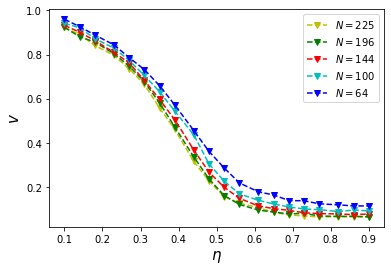

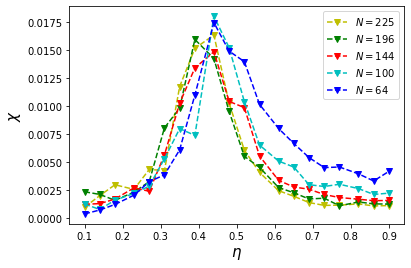

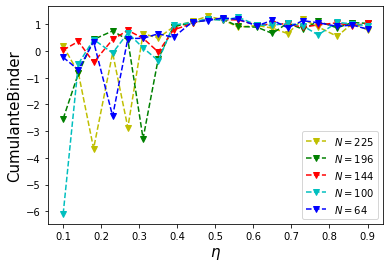

fet


In [150]:
StatsLabels_A=[r'$N=%s$'%N[k] for k in range(nroFilesA)]
formatos=['yv--','gv--','rv--','cv--','bv--']


graficoOP=[[eta,PhiMean_A[k],None,formatos[k],StatsLabels_A[k]] for k in range(nroFilesA)]
graficoSuc=[[eta,PhiVar_A[k],None,formatos[k],StatsLabels_A[k]]for k in range(nroFilesA)]
graficosCB=[[eta[:],PhiCB_A[k][:],None,formatos[k],StatsLabels_A[k]]for k in range(nroFilesA)]

plt.figure(9)
Graficador(graficoOP,r'$\eta$',r'$v$','')
plt.figure(10)
Graficador(graficoSuc,'$\eta$',r'$\chi$','')
plt.figure(11)
Graficador(graficosCB,'$\eta$','CumulanteBinder','')
print('fet')

[0.3154791036685, 0.33635189676899996, 0.3677648068169999, 0.43642034253350004, 0.455574708642] [0.01632918904632893, 0.015936057050710977, 0.014834434405723552, 0.018010646185017867, 0.017443526935012565]


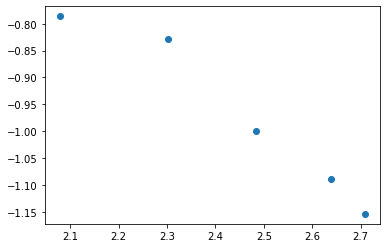

In [155]:
L=[15,14,12,10,8]

maxsv=[]
maxsus=[]
for k in range(nroFilesA):
    maxsv.append(PhiMean_A[k][8])
    maxsus.append(max(PhiVar_A[k]))
    


print(maxsv,maxsus)

plt.plot(np.log(L),np.log(maxsv), 'o')
plt.show()

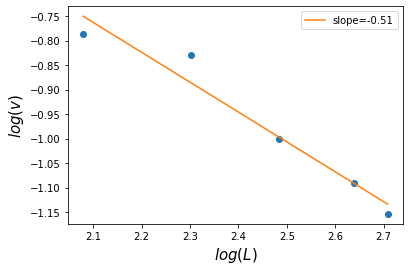

slope is -0.6099057989512823


In [168]:
plt.plot(np.log(L),np.log(maxsv), 'o')
m,b=np.polyfit(np.log(L),np.log(maxsv), 1)
plt.plot(np.log(L), m*np.log(L)+b, label='slope=-0.51')
plt.xlabel(r'$log(L)$', fontsize=15)
plt.ylabel(r'$log(v)$', fontsize=15)
plt.legend()
plt.show()

print('slope is', m)

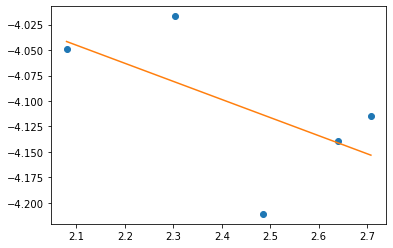

slope is -0.1774612781974995


In [158]:
plt.plot(np.log(L),np.log(maxsus), 'o')
m,b=np.polyfit(np.log(L),np.log(maxsus), 1)
plt.plot(np.log(L), m*np.log(L)+b)
plt.show()

print('slope is', m)

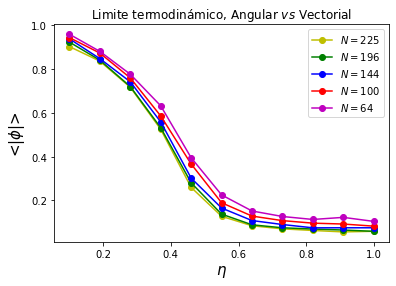

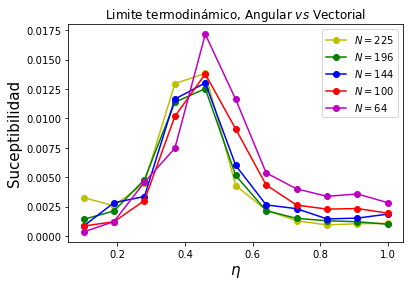

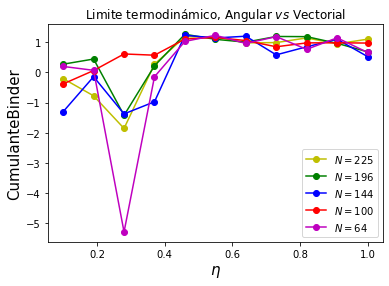

fet


In [90]:
StatsLabels_A=['$N=%s$'%N[k] for k in range(nroFilesA)]
formatos=['yo-','go-','bo-','ro-','mo-']

graficoOP=[[eta,PhiMean_A[k],None,formatos[k],StatsLabels_A[k]] for k in range(nroFilesA)]
graficoSuc=[[eta,PhiVar_A[k],None,formatos[k],StatsLabels_A[k]]for k in range(nroFilesA)]
graficosCB=[[eta[:],PhiCB_A[k][:],None,formatos[k],StatsLabels_A[k]]for k in range(nroFilesA)]

plt.figure(9)
Graficador(graficoOP,'$\eta$','<|$\phi$|>','Limite termodinámico, Angular $vs$ Vectorial')
plt.figure(10)
Graficador(graficoSuc,'$\eta$','Suceptibilidad','Limite termodinámico, Angular $vs$ Vectorial')
plt.figure(11)
Graficador(graficosCB,'$\eta$','CumulanteBinder','Limite termodinámico, Angular $vs$ Vectorial')
print('fet')

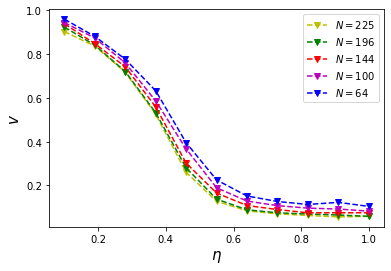

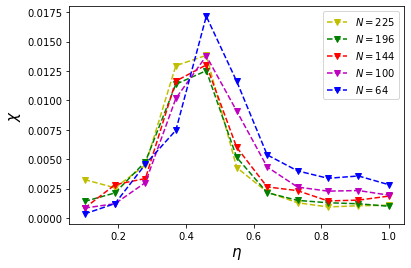

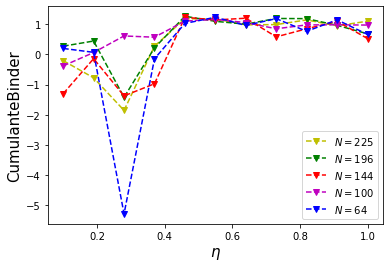

fet


In [102]:
StatsLabels_A=['$N=%s$'%N[k] for k in range(nroFilesA)]
formatos=['yv--','gv--','rv--','mv--','bv--']


graficoOP=[[eta,PhiMean_A[k],None,formatos[k],StatsLabels_A[k]] for k in range(nroFilesA)]
graficoSuc=[[eta,PhiVar_A[k],None,formatos[k],StatsLabels_A[k]]for k in range(nroFilesA)]
graficosCB=[[eta[:],PhiCB_A[k][:],None,formatos[k],StatsLabels_A[k]]for k in range(nroFilesA)]

plt.figure(9)
Graficador(graficoOP,r'$\eta$',r'$v$','')
plt.figure(10)
Graficador(graficoSuc,'$\eta$',r'$\chi$','')
plt.figure(11)
Graficador(graficosCB,'$\eta$','CumulanteBinder','')
print('fet')

In [148]:
L=[15,14,12,10,8]

maxsv=[]
maxsus=[]
for k in range(nroFilesV):
    maxsv.append(PhiMean_A[k][10])
    maxsus.append(max(PhiVar_A[k]))
    


print(maxsv,maxsus)

plt.plot(np.log(L),np.log(maxsv), 'o')
plt.show()

[0.1  0.14 0.18 0.23 0.27 0.31 0.35 0.39 0.44 0.48 0.52 0.56 0.61 0.65
 0.69 0.73 0.77 0.82 0.86 0.9 ] [0.33999999999999997, 0.3, 0.26, 0.21, 0.16999999999999998, 0.13, 0.09000000000000002, 0.04999999999999999, 0.0, 0.03999999999999998, 0.08000000000000002, 0.12000000000000005, 0.16999999999999998, 0.21000000000000002, 0.24999999999999994, 0.29, 0.33, 0.37999999999999995, 0.42, 0.46]


In [ ]:
PhiMean_A=[VA_OBJ[k].get_OP_Mean(tauEq_A[k]) for k in range(nroFilesA)]
PhiVar_A=[VA_OBJ[k].get_OP_Var(tauEq_A[k]) for k in range(nroFilesA)]
PhiCB_A=[VA_OBJ[k]._calc_X_BinderCumulant(tauEq_A[k]) for k in range(nroFilesA)]

print(PhiMean_A[0], np.sqrt(PhiVar_A))